# Spatial join

In this new notebook, we will dive into **spatial join**, another classic GIS task. This implies retrieving table attributes from one layer and transferring them into another layer based on their spatial relationship. We could, for example, join the attributes of a polygon layer into a point layer where each point would get the attributes of a polygon that intersects with the point.

#### The basic logic of spatial join

In Figure 1, we show how a spatial join works, combining information between spatial data layers that are located in the same area (they overlap at least partially). The target here is to combine attribute information of three layers: **properties, land use and buildings**. Each of these three layers has their own attribute information.

Transfering the information between the layers is based on how the individual points in the **Properties** layer intersect with these layers as shown on the left: considering different **land use areas** (commercial, residential, industrial, natural), as well as the **building** footprints containing a variety of building-related attibute information. On the right, we show the table attributes for these three layers considering the features that intersect with the four Point observations. The table at the bottom shows how the results look after all the attribute data from these layers has been combined into a single table.

Spatial join is always conducted between two layers at a time. Hence, in practice, if we want to make a spatial join between these three layers shown in Figure 1, we first need to conduct the spatial join between Properties and Land use, and then store this information into an intermediate result. After the first join, we need to make another spatial join between the intermediate result and the third layer (here, the Buildings dataset). After these two separate spatial joins, we have achieved the final result shown at the bottom, showing for each property (row) the corresponding attributes from the land use and building layers as separate columns. In a similar manner, you could also continue joining data (attributes) from other layers as long as you need.

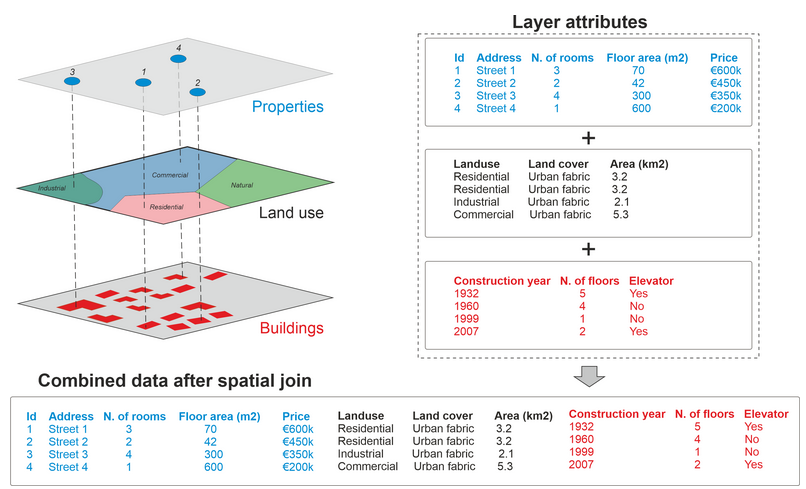

*Figure 1*. Spatial join allows you to combine attribute information from multiple layers based on spatial relationship. Credits to Henrikki Tenkanen, Vuokko Heikinheimo, and David Whipp.

In spatial join, there are two set of options that you can control, which ultimately influence how the data is transferred between the layers. You can control:

- How the spatial relationship between geometries should be checked (i.e. spatial predicates), and

- What type of table join you want to conduct (inner, left, or right outer join)

The spatial predicates control how the spatial relationship between the geometries in the two data layers is checked. Only those cases where the spatial predicate returns True will be kept in the result. Thus, changing this option (parameter) can have a big influence on your final results after the join. 

In Figure 2 this difference is illustrated at the bottom when you compare the result tables i and ii: In the first table (i) the spatial predicate is within that gives us 4 rows that is shown in the table. However, on the second result table (ii), the spatial predicate intersects gives us 5 rows. Why is there a difference? This is because the Point with id-number 6 happens to lie exactly at the border of the Polygon C. There is a certain difference between these two spatial predicates: The within predicate expects that the Point should be inside the Polygon (False in our case), whereas intersects returns True if at least one point is common between the geometries (True in our case). In a similar manner, you could change the spatial predicate to contains, touches, overlaps etc. and the result would change accordingly.

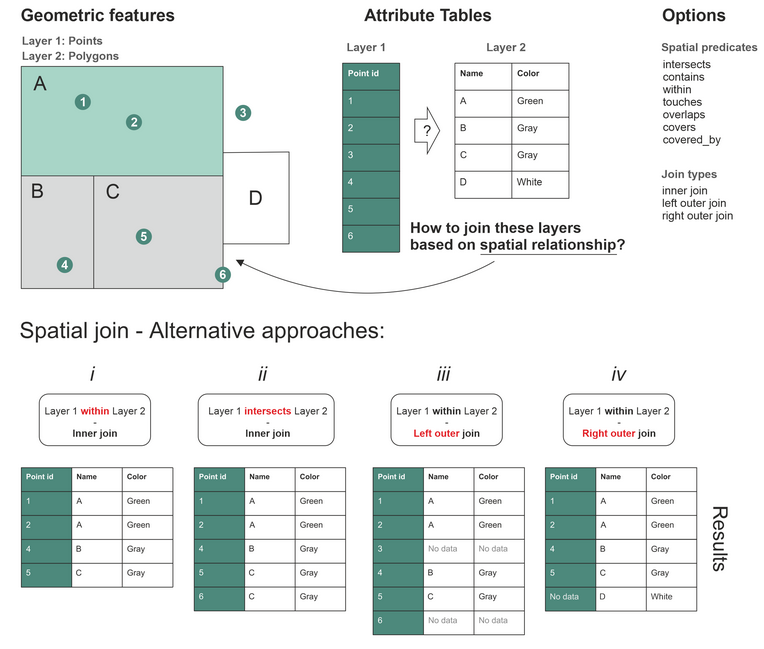

*Figure 2.* Different approaches to join two data layers with each other based on spatial relationships. Credits to Henrikki Tenkanen, Vuokko Heikinheimo, and David Whipp.

The other parameter that you can use to control how the spatial join is conducted is the spatial join type. There are three different join types that influence the outcome of the spatial join:

- inner join

- left outer join

- right outer join

The terms left and right correspond to the two data layers/tables used in the spatial join, and specifically to the order how these layers are used in the spatial join. In our case, the Layer 1 represents always the left side of spatial join (indicated with green background color in the tables of Figure 2), whereas the Layer 2 corresponds to the right accordingly (white background). The result table iii shows an example of left outer join in which all the rows from the left are kept (no matter what), and the ones from the right that have a match based on spatial predicate will be added to the result. In case some of the rows on the left do not have a match with the right layer, those attributes will receive NaN (No data) as the attribute value as shown with Point id 3 and 6 in the result table iii. The right outer join works in quite a similar manner, but in this case the values on the right layer are always kept (no matter what), and only the ones from the left that have a match based on the spatial predicate will be kept. The rows without a match will receive a Nan (No data) on the left side as shown in result table iv with Polygon that has a Name D.

When looking at the result tables i and ii (Figure 1), we can see that both spatial joins have been conducted using an inner join. When using the inner join, we only keep such rows from the right and left tables that have received True after testing the relationship based on the chosen spatial predicate. 


#### Spatial join with Python

Spatial join can be done easily with geopandas using the **.sjoin()** method. In this example, it will be used to perform a spatial join between two layers: 1) *addresses* which are the locations that we geocoded in previous parts of this series, and 2) *population grid* which is a 250m x 250m grid polygon layer that contains population information from the Helsinki Region. Let’s start by reading the data:

In [14]:
# Import packages
import geopandas as gpd

# Read the addresses data
addr_fp = "data/Helsinki/addresses.shp"
addresses = gpd.read_file(addr_fp)
addresses.head(2)

geometry
0   POINT (24.91556 60.1632)
1  POINT (24.93166 60.16905)

The *addresses* variable contains address Points which represent a selection of public transport stations in the Helsinki Region.

In [15]:
# Read the population data
pop_grid_fp = "data/Helsinki/Population_grid_2021_HSY.gpkg"
pop_grid = gpd.read_file(pop_grid_fp)
pop_grid.head(2)

id  inhabitants  occupancy_rate  \
0  Vaestotietoruudukko_2021.1            5           50.60   
1  Vaestotietoruudukko_2021.2            7           36.71   

                                            geometry  
0  POLYGON ((25472499.995 6689749.005, 25472499.9...  
1  POLYGON ((25472499.995 6685998.998, 25472499.9...

The *pop_grid* dataset contains few columns, namely a unique *id*, the number of *inhabitants* per grid cell, and the *occupancy_rate* as percentage.

The first step before making a spatial join, it is always good to check that the coordinate reference system (CRS) of the layers are identical. The basic requirement for a successful spatial join is that the layers should overlap with each other in space. If the geometries between the layers do not share the same CRS, it is very likely that the spatial join will fail and produces an empty GeoDataFrame. By looking at the numbers in the geometry column of the addresses and pop_grid GeoDataFrames above, it is fairly evident that the datasets are in different coordinate reference system as the numbers seem to differ a lot. Let’s check the CRS information of each layer:

In [16]:
# Print the CRS information of each layer
print("Address points CRS:", addresses.crs.name)
print("Population grid CRS:", pop_grid.crs.name)

Address points CRS: WGS 84
Population grid CRS: EUREF-FIN / GK25FIN


To fix it, we can reproject the geometries in the addresses GeoDataFrame to the same CRS as pop_grid using the *.to_crs()* method. To ensure that we will have exactly the same CRS in both layers, we can use the *pop_grid.crs* attribute information as the input for the crs parameter:

In [17]:
# Reproject
addresses = addresses.to_crs(crs=pop_grid.crs)

# Validate match (must return True)
addresses.crs == pop_grid.crs

True

Now the datasets share the same coordinate reference system. 

As a last preparatory step, let’s visualize both datasets on top of each other to see how the inhabitants are distributed over the region, and how the address points are located in relation to the grid:

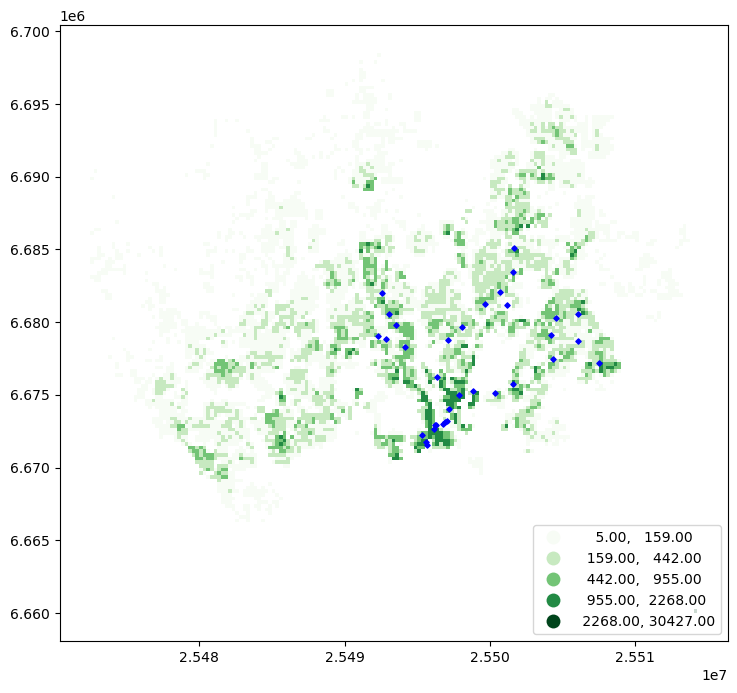

In [18]:
# Plot the population data classified into 5 classes
ax = pop_grid.plot(
    column="inhabitants",
    cmap="Greens",
    scheme="naturalbreaks",
    k=5,
    legend=True,
    legend_kwds={"loc": "lower right"},
    figsize=(10, 8),
)

# Add address points on top using blue "Diamond" markers
ax = addresses.plot(ax=ax, color="blue", markersize=7, marker="D")

The Polygons representing the population distribution in the area overlap nicely with the address locations and we are ready to join information among these two layers based on their spatial relationship.

#### Join the layers based on spatial relationship

Let's now perform the spatial join between our two data layers. The aim here is to get information about how many people live in a given polygon that contains an individual address-point. Thus, we want to join the attribute information from the pop_grid layer into the addresses Point layer using the *.sjoin()* method.

The addresses GeoDataFrame containing the points is the one we want to use as a starting point, as this layer is the receiving member of the spatial join. Futhermore, we specify predicate="within" for the spatial predicate as we are interested to know within which polygon a given point is located. Finally, we specify the join type with how="inner" which means that only such rows are kept from both layers where the spatial predicate returns True. This means that if there are points that are not inside of any of the Polygons, they will be dropped from the result. 

In [19]:
# Perform the spatial join
join = addresses.sjoin(pop_grid, predicate="within", how="inner")
join

geometry  index_right  \
0   POINT (25495311.608 6672258.695)         3262   
1   POINT (25496206.216 6672909.016)         3381   
2   POINT (25496762.723 6673010.538)         3504   
3   POINT (25498815.415 6675246.744)         3845   
4   POINT (25495641.151 6671525.076)         3310   
5   POINT (25504528.607 6680282.118)         5058   
6     POINT (25506082.816 6678702.5)         5407   
7   POINT (25501631.384 6685110.943)         4302   
8   POINT (25501586.789 6683452.706)         4309   
10  POINT (25496896.718 6673162.114)         3504   
11  POINT (25493506.585 6679793.504)         2985   
12  POINT (25493093.193 6680589.107)         2886   
13  POINT (25497118.126 6678784.269)         3535   
14  POINT (25500717.139 6682045.953)         4114   
15  POINT (25494134.034 6678278.391)         3079   
16  POINT (25492575.043 6681972.681)         2775   
17  POINT (25498089.949 6679640.055)         3728   
19  POINT (25492287.623 6679040.234)         2723   
20  POINT (25499646.711 6681218.844)         3945   
22  POINT (25504344.005 6677452.185)         5008   
23  POINT (25507495.008 6677173.504)         5626   
24  POINT (25504169.174 6679129.384)         4942   
25   POINT (25506082.506 6680577.96)         5399   
26  POINT (25497840.365 6675020.358)         3696   
27  POINT (25501570.947 6675734.321)         4330   
28  POINT (25500377.732 6675098.523)         4079   
29  POINT (25497199.344 6674065.972)         3552   
30  POINT (25496286.911 6672913.768)         3411   
31  POINT (25496128.995 6672625.288)         3382   
32  POINT (25495624.409 6671766.187)         3309   
33  POINT (25497062.747 6673226.621)         3555   

                               id  inhabitants  occupancy_rate  
0   Vaestotietoruudukko_2021.3263          505           14.01  
1   Vaestotietoruudukko_2021.3382          172           27.67  
2   Vaestotietoruudukko_2021.3505           43           61.44  
3   Vaestotietoruudukko_2021.3846          757           33.98  
4   Vaestotietoruudukko_2021.3311         1402           29.76  
5   Vaestotietoruudukko_2021.5059          283           20.51  
6   Vaestotietoruudukko_2021.5408          155           43.42  
7   Vaestotietoruudukko_2021.4303          236           37.62  
8   Vaestotietoruudukko_2021.4310          253           33.56  
10  Vaestotietoruudukko_2021.3505           43           61.44  
11  Vaestotietoruudukko_2021.2986          629           36.11  
12  Vaestotietoruudukko_2021.2887          817           29.63  
13  Vaestotietoruudukko_2021.3536          163           33.08  
14  Vaestotietoruudukko_2021.4115           99           33.06  
15  Vaestotietoruudukko_2021.3080          425           37.04  
16  Vaestotietoruudukko_2021.2776          353           32.35  
17  Vaestotietoruudukko_2021.3729          255           38.51  
19  Vaestotietoruudukko_2021.2724          231           33.98  
20  Vaestotietoruudukko_2021.3946          336           35.39  
22  Vaestotietoruudukko_2021.5009          453           21.73  
23  Vaestotietoruudukko_2021.5627          231           35.18  
24  Vaestotietoruudukko_2021.4943          638           33.41  
25  Vaestotietoruudukko_2021.5400          361           24.29  
26  Vaestotietoruudukko_2021.3697          829           33.92  
27  Vaestotietoruudukko_2021.4331          271           37.29  
28  Vaestotietoruudukko_2021.4080          321           38.40  
29  Vaestotietoruudukko_2021.3553          215           43.71  
30  Vaestotietoruudukko_2021.3412          286           25.86  
31  Vaestotietoruudukko_2021.3383         1409           32.37  
32  Vaestotietoruudukko_2021.3310          995           37.07  
33  Vaestotietoruudukko_2021.3556          281           36.14

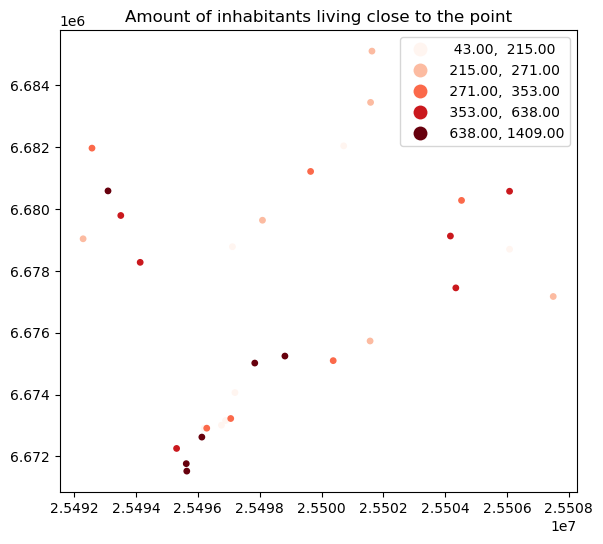

In [20]:
# And plot it
ax = join.plot(
    column="inhabitants",
    cmap="Reds",
    markersize=15,
    scheme="quantiles",
    legend=True,
    figsize=(10, 6),
)
ax.set_title("Amount of inhabitants living close to the point");

Now we have performed a successful spatial join that gave us as a result 31 rows and four new columns. Most importantly, we received information about inhabitants and occupancy_rate which correspond to the number of inhabitants and occupancy rate in the cell where the address-point is located. In the plot, it can be seen that the number of population living close to the stations vary quite significantly ranging from 43 up to 1409 inhabitants. 

As a last thing after the spatial join, it is useful to investigate if we lost any data while doing the spatial join. Let’s check this by comparing the number of rows in our result to how many addresses we had originally:

In [21]:
# Check the difference in number of rows between the original data and the result of the join 
len(addresses) - len(join)


3

There seems to be three Points that were located outside of the populated grid cells. If we plot the layers on top of each other as an interactive map, we can investigate where the points outside of polygons are located:

In [22]:
# Plot the interactive map
m = pop_grid.explore(color="blue", style_kwds=dict(color="blue", stroke=False))
addresses.explore(m=m, color="red")

We can see that some points are located outside of polygons in the areas close to the railway lines and the motorway. Is this a problem? It depends, but in certain cases, you might want to keep the information for the points that did not get a match based on the spatial relationship. This can be done by changing the **how** parameter into left, which keeps every row from the left member of the spatial join even when no match is found from the other layer:

In [23]:
# Left join of the tables
left_join = addresses.sjoin(pop_grid, predicate="within", how="left")
left_join

geometry  index_right  \
0   POINT (25495311.608 6672258.695)       3262.0   
1   POINT (25496206.216 6672909.016)       3381.0   
2   POINT (25496762.723 6673010.538)       3504.0   
3   POINT (25498815.415 6675246.744)       3845.0   
4   POINT (25495641.151 6671525.076)       3310.0   
5   POINT (25504528.607 6680282.118)       5058.0   
6     POINT (25506082.816 6678702.5)       5407.0   
7   POINT (25501631.384 6685110.943)       4302.0   
8   POINT (25501586.789 6683452.706)       4309.0   
9   POINT (25492851.783 6678869.234)          NaN   
10  POINT (25496896.718 6673162.114)       3504.0   
11  POINT (25493506.585 6679793.504)       2985.0   
12  POINT (25493093.193 6680589.107)       2886.0   
13  POINT (25497118.126 6678784.269)       3535.0   
14  POINT (25500717.139 6682045.953)       4114.0   
15  POINT (25494134.034 6678278.391)       3079.0   
16  POINT (25492575.043 6681972.681)       2775.0   
17  POINT (25498089.949 6679640.055)       3728.0   
18     POINT (25496358.8 6676198.28)          NaN   
19  POINT (25492287.623 6679040.234)       2723.0   
20  POINT (25499646.711 6681218.844)       3945.0   
21  POINT (25501142.787 6681208.443)          NaN   
22  POINT (25504344.005 6677452.185)       5008.0   
23  POINT (25507495.008 6677173.504)       5626.0   
24  POINT (25504169.174 6679129.384)       4942.0   
25   POINT (25506082.506 6680577.96)       5399.0   
26  POINT (25497840.365 6675020.358)       3696.0   
27  POINT (25501570.947 6675734.321)       4330.0   
28  POINT (25500377.732 6675098.523)       4079.0   
29  POINT (25497199.344 6674065.972)       3552.0   
30  POINT (25496286.911 6672913.768)       3411.0   
31  POINT (25496128.995 6672625.288)       3382.0   
32  POINT (25495624.409 6671766.187)       3309.0   
33  POINT (25497062.747 6673226.621)       3555.0   

                               id  inhabitants  occupancy_rate  
0   Vaestotietoruudukko_2021.3263        505.0           14.01  
1   Vaestotietoruudukko_2021.3382        172.0           27.67  
2   Vaestotietoruudukko_2021.3505         43.0           61.44  
3   Vaestotietoruudukko_2021.3846        757.0           33.98  
4   Vaestotietoruudukko_2021.3311       1402.0           29.76  
5   Vaestotietoruudukko_2021.5059        283.0           20.51  
6   Vaestotietoruudukko_2021.5408        155.0           43.42  
7   Vaestotietoruudukko_2021.4303        236.0           37.62  
8   Vaestotietoruudukko_2021.4310        253.0           33.56  
9                             NaN          NaN             NaN  
10  Vaestotietoruudukko_2021.3505         43.0           61.44  
11  Vaestotietoruudukko_2021.2986        629.0           36.11  
12  Vaestotietoruudukko_2021.2887        817.0           29.63  
13  Vaestotietoruudukko_2021.3536        163.0           33.08  
14  Vaestotietoruudukko_2021.4115         99.0           33.06  
15  Vaestotietoruudukko_2021.3080        425.0           37.04  
16  Vaestotietoruudukko_2021.2776        353.0           32.35  
17  Vaestotietoruudukko_2021.3729        255.0           38.51  
18                            NaN          NaN             NaN  
19  Vaestotietoruudukko_2021.2724        231.0           33.98  
20  Vaestotietoruudukko_2021.3946        336.0           35.39  
21                            NaN          NaN             NaN  
22  Vaestotietoruudukko_2021.5009        453.0           21.73  
23  Vaestotietoruudukko_2021.5627        231.0           35.18  
24  Vaestotietoruudukko_2021.4943        638.0           33.41  
25  Vaestotietoruudukko_2021.5400        361.0           24.29  
26  Vaestotietoruudukko_2021.3697        829.0           33.92  
27  Vaestotietoruudukko_2021.4331        271.0           37.29  
28  Vaestotietoruudukko_2021.4080        321.0           38.40  
29  Vaestotietoruudukko_2021.3553        215.0           43.71  
30  Vaestotietoruudukko_2021.3412        286.0           25.86  
31  Vaestotietoruudukko_2021.3383       1409.0           32.37  
32  Vaestotietoruudukko_202

Now the result in the left_join contains all the original 34 addresses. Let’s investigate a bit more to see which rows did not have a matching polygon in the population grid. After a left-join, those rows that do not have a matching geometry in the right-side member of the join are filled with NaN values. Thus, we should be able to locate them easily by searching for rows that do not have any values e.g. in the inhabitants column that was part of the pop_grid GeoDataFrame. We can do this by doing a selection using the *.isnull()* method:

In [24]:
# Check for the non-matching observations
left_join.loc[left_join["inhabitants"].isnull()]

geometry  index_right   id  inhabitants  \
9   POINT (25492851.783 6678869.234)          NaN  NaN          NaN   
18     POINT (25496358.8 6676198.28)          NaN  NaN          NaN   
21  POINT (25501142.787 6681208.443)          NaN  NaN          NaN   

    occupancy_rate  
9              NaN  
18             NaN  
21             NaN

The result from this query reveals the exact locations of the points that miss information in the last four columns of the GeoDataFrame. 

This will do for this chapter, let's follow on the next!